In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../filled.csv')

In [3]:
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,0.0,5.0,-1.00,0.0,2.0,8.0,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,0.0,4.0,-1.00,0.0,3.0,5.0,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,Student,5.0,0.0,8.97,2.0,0.0,5.5,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,0.0,5.0,-1.00,0.0,1.0,5.0,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,0.0,1.0,-1.00,0.0,1.0,5.5,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
df.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

# Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from collections import Counter


In [6]:
X = df.drop(['id', 'Name', 'Depression'], axis=1)
y = df['Depression']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112560, 17), (28140, 17), (112560,), (28140,))

In [8]:
num_attrs = X.select_dtypes(include='number').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [9]:
str_attrs = X.select_dtypes(include='object').columns
str_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [10]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attrs),
    ('str', str_pipeline, str_attrs)
])

In [11]:
X_train_processed = full_pipeline.fit_transform(X_train)
X_test_processed = full_pipeline.transform(X_test)

In [12]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 92147, 1: 20413})
Counter({0: 22986, 1: 5154})


# Import Evaluate Library

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

# Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

## Xây dựng cây không điều chỉnh tham số

In [21]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_processed, y_train)
y_pred = dtc.predict(X_test_processed)

print('Classification Report on Train Set')
print(classification_report(y_train, dtc.predict(X_train_processed)))

print('Classification Report on Test Set')
print(classification_report(y_test, dtc.predict(X_test_processed)))

Classification Report on Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     92147
           1       1.00      1.00      1.00     20413

    accuracy                           1.00    112560
   macro avg       1.00      1.00      1.00    112560
weighted avg       1.00      1.00      1.00    112560

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     22986
           1       0.72      0.75      0.73      5154

    accuracy                           0.90     28140
   macro avg       0.83      0.84      0.84     28140
weighted avg       0.90      0.90      0.90     28140



## Lựa chọn các tham số Pre-Pruning

In [133]:
max_depth = [20, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 8, 16, 18, 20]

In [134]:
from joblib import Parallel, delayed

train_accs = []
test_accs = []
train_f1s = []
test_f1s = []
train_pres = []
test_pres = []
train_recs = []
test_recs = []

def evaluate_model(depth, split, leaf):
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
    model.fit(X_train_processed, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train_processed))
    test_acc = accuracy_score(y_test, model.predict(X_test_processed))
    train_f1 = f1_score(y_train, model.predict(X_train_processed))
    test_f1 = f1_score(y_test, model.predict(X_test_processed))
    train_pre = precision_score(y_train, model.predict(X_train_processed))
    test_pre = precision_score(y_test, model.predict(X_test_processed))
    train_rec = recall_score(y_train, model.predict(X_train_processed))
    test_rec = recall_score(y_test, model.predict(X_test_processed))

    return train_acc, test_acc, train_f1, test_f1, train_pre, test_pre, train_rec, test_rec

results = Parallel(n_jobs=-1)(delayed(evaluate_model)(depth, split, leaf) for depth in max_depth for split in min_samples_split for leaf in min_samples_leaf)

for result in results:
    train_accs.append(result[0])
    test_accs.append(result[1])
    train_f1s.append(result[2])
    test_f1s.append(result[3])
    train_pres.append(result[4])
    test_pres.append(result[5])
    train_recs.append(result[6])
    test_recs.append(result[7])

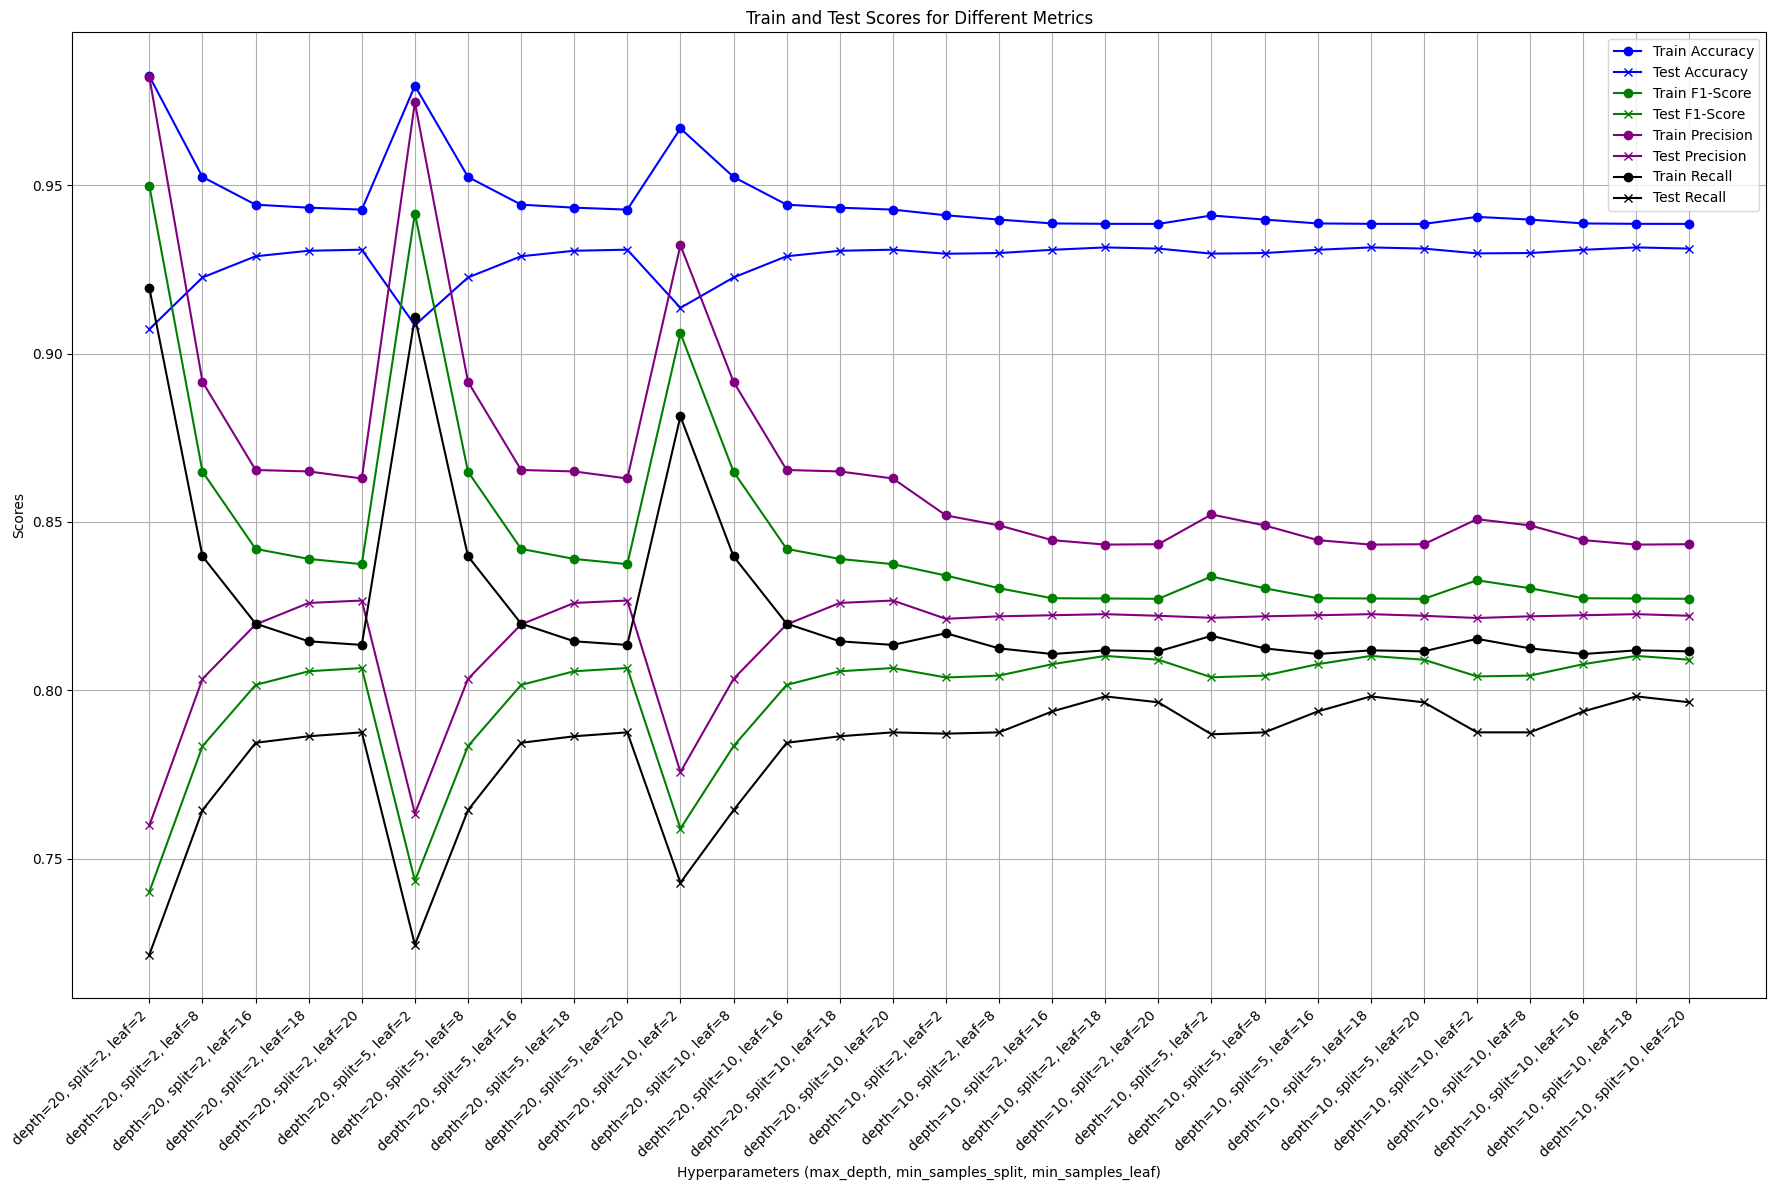

In [135]:
x_labels = [f"depth={d}, split={s}, leaf={l}" for d in max_depth for s in min_samples_split for l in min_samples_leaf]
x_range = np.arange(len(x_labels)) 

# Tạo đồ thị tổng hợp
plt.figure(figsize=(18, 12))

# Accuracy
plt.plot(x_range, train_accs, label='Train Accuracy', marker='o', color='blue')
plt.plot(x_range, test_accs, label='Test Accuracy', marker='x', color='blue')

# F1-Score
plt.plot(x_range, train_f1s, label='Train F1-Score', marker='o', color='green')
plt.plot(x_range, test_f1s, label='Test F1-Score', marker='x', color='green')

# Precision
plt.plot(x_range, train_pres, label='Train Precision', marker='o', color='purple')
plt.plot(x_range, test_pres, label='Test Precision', marker='x', color='purple')

# Recall
plt.plot(x_range, train_recs, label='Train Recall', marker='o', color='black')
plt.plot(x_range, test_recs, label='Test Recall', marker='x', color='black')

plt.xticks(x_range, x_labels, rotation=45, ha='right')
plt.xlabel('Hyperparameters (max_depth, min_samples_split, min_samples_leaf)')
plt.ylabel('Scores')
plt.title('Train and Test Scores for Different Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [181]:
dtc = DecisionTreeClassifier( \
    max_depth=10, min_samples_split=2, \
    min_samples_leaf=18,\
    random_state=42)

dtc.fit(X_train_processed, y_train)
y_pred = dtc.predict(X_test_processed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.80      0.81      5154

    accuracy                           0.93     28140
   macro avg       0.89      0.88      0.88     28140
weighted avg       0.93      0.93      0.93     28140



## Lựa chọn tham số alpha cho Post-Pruning (CCP)

In [169]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=18, random_state=42)

weight0 = y.shape[0] / (2 * Counter(y_train)[0])
weight1 = y.shape[0] / (2 * Counter(y_train)[1])

sample_weight = np.where(y_train == 0, weight0, weight1)

path = dtc.cost_complexity_pruning_path(X_train_processed, y_train, sample_weight=sample_weight)

# Các giá trị alpha
ccp_alphas = path.ccp_alphas[300:461]

print(ccp_alphas.shape)
print(max(ccp_alphas), min(ccp_alphas))


(161,)
9.401912713774573e-05 3.5439749637274955e-05


In [170]:
from joblib import Parallel, delayed

# Huấn luyện với từng giá trị alpha
def eval_dtc(ccp_alpha):
    dtc = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=18, ccp_alpha=ccp_alpha, random_state=42)
    
    score = cross_val_score(dtc, X_train_processed, y_train, cv=5, scoring='f1').mean()
    return score

scores = Parallel(n_jobs=-1)(delayed(eval_dtc)(ccp_alpha) for ccp_alpha in ccp_alphas)

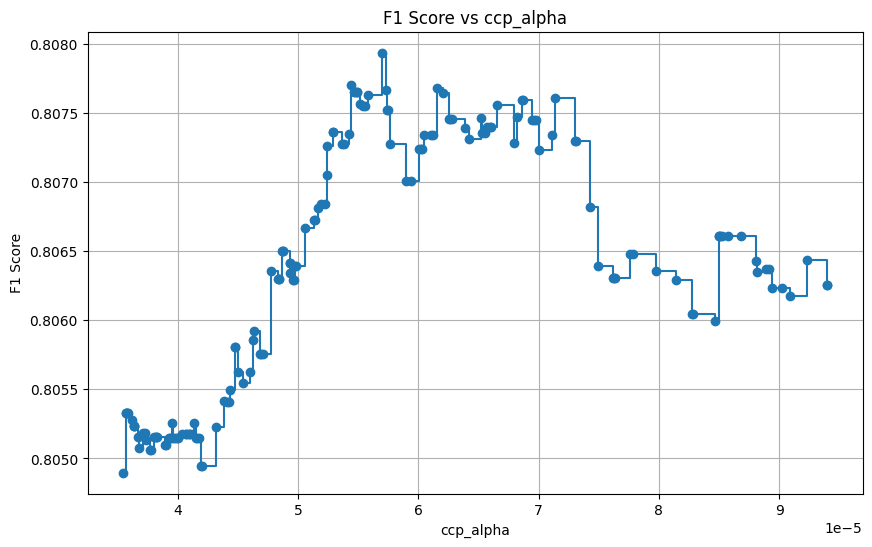

Best ccp_alpha: 5.695542462611446e-05


In [171]:
best_alpha = ccp_alphas[np.argmax(scores)]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, scores, marker='o', drawstyle='steps-post')
plt.xlabel('ccp_alpha')
plt.ylabel('F1 Score')
plt.title('F1 Score vs ccp_alpha')
plt.grid(True)
plt.show()

print('Best ccp_alpha:', best_alpha)

In [183]:
dtc = DecisionTreeClassifier( \
    max_depth=10, min_samples_split=2, \
    min_samples_leaf=18, ccp_alpha=5.7e-05, \
    random_state=42)

dtc.fit(X_train_processed, y_train)
y_pred = dtc.predict(X_test_processed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.80      0.81      5154

    accuracy                           0.93     28140
   macro avg       0.89      0.88      0.88     28140
weighted avg       0.93      0.93      0.93     28140



# Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train_processed, y_train)
print('Classification Report on Train Set')
print(classification_report(y_train, rfc.predict(X_train_processed)))
print('Classification Report on Test Set')
print(classification_report(y_test, rfc.predict(X_test_processed)))

Classification Report on Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     92147
           1       1.00      1.00      1.00     20413

    accuracy                           1.00    112560
   macro avg       1.00      1.00      1.00    112560
weighted avg       1.00      1.00      1.00    112560

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.85      0.80      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [35]:
max_depth = [20, 10]
min_samples_split = [2, 5, 10, 15, 20]
n_estimatorss = [64, 100, 128]

In [17]:
train_accs = []
test_accs= []
train_f1s = []
test_f1s = []
train_pres = []
test_pres = []
train_recs = []
test_recs = []

for n in n_estimatorss:
    for depth in max_depth:
        for split in min_samples_split:
            model = RandomForestClassifier(max_depth=depth, min_samples_split=split, n_jobs=-1, n_estimators=n, random_state=42)
            model.fit(X_train_processed, y_train)

            train_acc = accuracy_score(y_train, model.predict(X_train_processed))
            test_acc = accuracy_score(y_test, model.predict(X_test_processed))
            train_f1 = f1_score(y_train, model.predict(X_train_processed))
            test_f1 = f1_score(y_test, model.predict(X_test_processed))
            train_pre = precision_score(y_train, model.predict(X_train_processed))
            test_pre = precision_score(y_test, model.predict(X_test_processed))
            train_rec = recall_score(y_train, model.predict(X_train_processed))
            test_rec = recall_score(y_test, model.predict(X_test_processed))

            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            train_pres.append(train_pre)
            test_pres.append(test_pre)
            train_recs.append(train_rec)
            test_recs.append(test_rec)

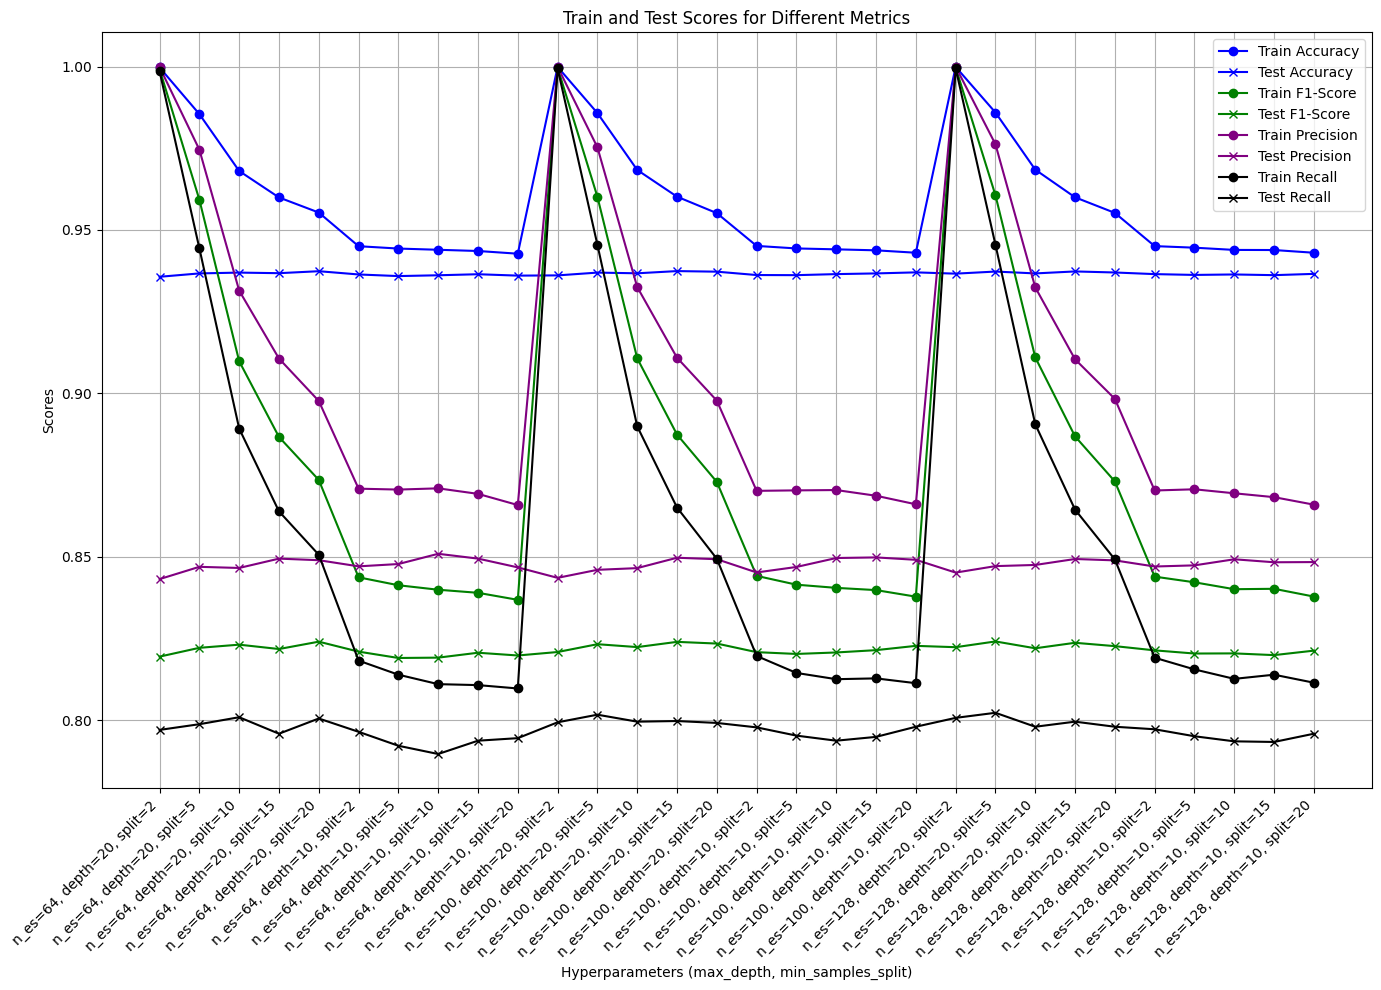

In [18]:
x_labels = [f"n_es={n}, depth={d}, split={s}" for n in n_estimatorss for d in max_depth for s in min_samples_split]
x_range = np.arange(len(x_labels)) 


# Tạo đồ thị tổng hợp
plt.figure(figsize=(14, 10))

# Accuracy
plt.plot(x_range, train_accs, label='Train Accuracy', marker='o', color='blue')
plt.plot(x_range, test_accs, label='Test Accuracy', marker='x', color='blue')

# F1-Score
plt.plot(x_range, train_f1s, label='Train F1-Score', marker='o', color='green')
plt.plot(x_range, test_f1s, label='Test F1-Score', marker='x', color='green')

# Precision
plt.plot(x_range, train_pres, label='Train Precision', marker='o', color='purple')
plt.plot(x_range, test_pres, label='Test Precision', marker='x', color='purple')

# Recall
plt.plot(x_range, train_recs, label='Train Recall', marker='o', color='black')
plt.plot(x_range, test_recs, label='Test Recall', marker='x', color='black')

plt.xticks(x_range, x_labels, rotation=45, ha='right')
plt.xlabel('Hyperparameters (max_depth, min_samples_split)')
plt.ylabel('Scores')
plt.title('Train and Test Scores for Different Metrics with class_weight = {}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rfc = RandomForestClassifier(min_samples_split=20, max_depth=10, n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train_processed, y_train)
print('Classification Report on Train Set')
print(classification_report(y_train, rfc.predict(X_train_processed)))
print('Classification Report on Test Set')
print(classification_report(y_test, rfc.predict(X_test_processed)))

Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     92147
           1       0.87      0.81      0.84     20413

    accuracy                           0.94    112560
   macro avg       0.91      0.89      0.90    112560
weighted avg       0.94      0.94      0.94    112560

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22986
           1       0.85      0.79      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.94     28140



In [25]:
import time

# Measure training time for the model without parameters
start_time = time.time()
rfc_no_params = RandomForestClassifier(random_state=42)
rfc_no_params.fit(X_train_processed, y_train)
train_time_no_params = time.time() - start_time

# Measure prediction time for the model without parameters
start_time = time.time()
y_pred_no_params = rfc_no_params.predict(X_test_processed)
predict_time_no_params = time.time() - start_time

# Measure training time for the model with parameters
start_time = time.time()
rfc_params = RandomForestClassifier(min_samples_split=20, max_depth=10, n_estimators=100, random_state=42)
rfc_params.fit(X_train_processed, y_train)
train_time_params = time.time() - start_time

# Measure prediction time for the model with parameters
start_time = time.time()
y_pred_params = rfc_params.predict(X_test_processed)
predict_time_params = time.time() - start_time

print(f"Training time (no params): {train_time_no_params:.4f} seconds")
print(f"Prediction time (no params): {predict_time_no_params:.4f} seconds")
print(f"Training time (with params): {train_time_params:.4f} seconds")
print(f"Prediction time (with params): {predict_time_params:.4f} seconds")
print(f"Training time speedup: {train_time_no_params / train_time_params:.2f}x")
print(f"Prediction time speedup: {predict_time_no_params / predict_time_params:.2f}x")


Training time (no params): 6.0893 seconds
Prediction time (no params): 0.2597 seconds
Training time (with params): 4.4822 seconds
Prediction time (with params): 0.1562 seconds
Training time speedup: 1.36x
Prediction time speedup: 1.66x


## Class weight

In [42]:
train_accs = []
test_accs= []
train_f1s = []
test_f1s = []
train_pres = []
test_pres = []
train_recs = []
test_recs = []

for depth in max_depth:
    for split in min_samples_split:
        model = RandomForestClassifier(max_depth=depth, min_samples_split=split, class_weight='balanced', n_jobs=-1, n_estimators=100, random_state=42)
        model.fit(X_train_processed, y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train_processed))
        test_acc = accuracy_score(y_test, model.predict(X_test_processed))
        train_f1 = f1_score(y_train, model.predict(X_train_processed))
        test_f1 = f1_score(y_test, model.predict(X_test_processed))
        train_pre = precision_score(y_train, model.predict(X_train_processed))
        test_pre = precision_score(y_test, model.predict(X_test_processed))
        train_rec = recall_score(y_train, model.predict(X_train_processed))
        test_rec = recall_score(y_test, model.predict(X_test_processed))

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        train_pres.append(train_pre)
        test_pres.append(test_pre)
        train_recs.append(train_rec)
        test_recs.append(test_rec)

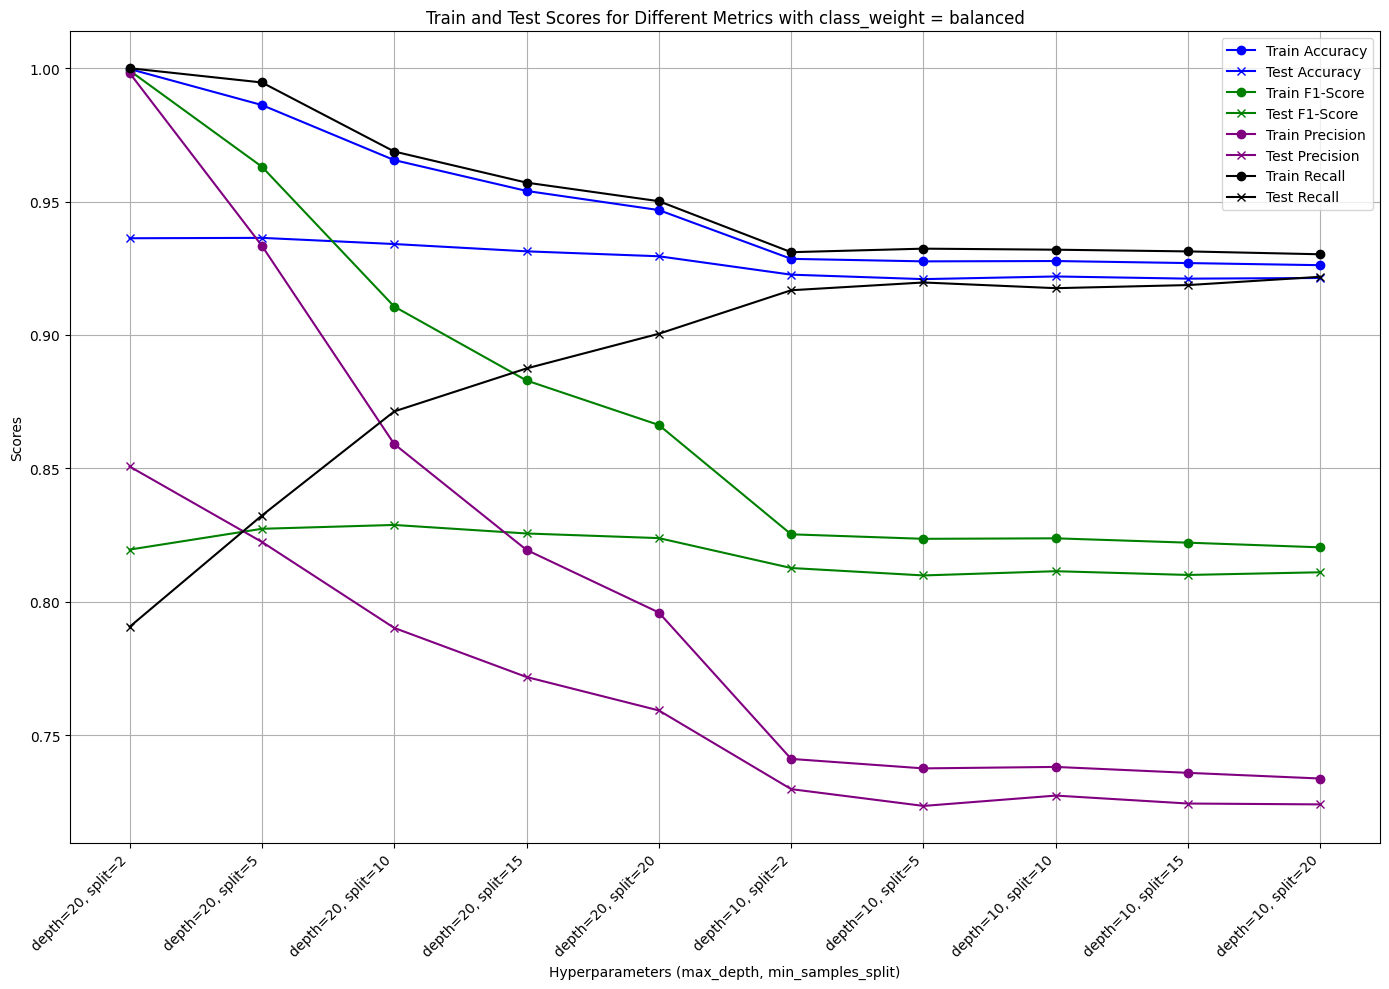

In [43]:
x_labels = [f"depth={d}, split={s}" for d in max_depth for s in min_samples_split]
x_range = np.arange(len(x_labels))

 # Tạo đồ thị tổng hợp
plt.figure(figsize=(14, 10))

# Accuracy
plt.plot(x_range, train_accs, label='Train Accuracy', marker='o', color='blue')
plt.plot(x_range, test_accs, label='Test Accuracy', marker='x', color='blue')

# F1-Score
plt.plot(x_range, train_f1s, label='Train F1-Score', marker='o', color='green')
plt.plot(x_range, test_f1s, label='Test F1-Score', marker='x', color='green')

# Precision
plt.plot(x_range, train_pres, label='Train Precision', marker='o', color='purple')
plt.plot(x_range, test_pres, label='Test Precision', marker='x', color='purple')

# Recall
plt.plot(x_range, train_recs, label='Train Recall', marker='o', color='black')
plt.plot(x_range, test_recs, label='Test Recall', marker='x', color='black')

plt.xticks(x_range, x_labels, rotation=45, ha='right')
plt.xlabel('Hyperparameters (max_depth, min_samples_split)')

plt.ylabel('Scores')
plt.title(f'Train and Test Scores for Different Metrics with class_weight = balanced')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
rfc = RandomForestClassifier(min_samples_split=5, max_depth=20, class_weight='balanced', n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train_processed, y_train)

print('Classification Report on Train Set')
print(classification_report(y_train, rfc.predict(X_train_processed)))
print('Classification Report on Test Set')
print(classification_report(y_test, rfc.predict(X_test_processed)))

Classification Report on Train Set
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     92147
           1       0.93      0.99      0.96     20413

    accuracy                           0.99    112560
   macro avg       0.97      0.99      0.98    112560
weighted avg       0.99      0.99      0.99    112560

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.83      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.89      0.90      0.89     28140
weighted avg       0.94      0.94      0.94     28140



## SMOTE 

Original dataset shape: Counter({0: 92147, 1: 20413})
Resampled dataset shape: Counter({0: 92147, 1: 92147})


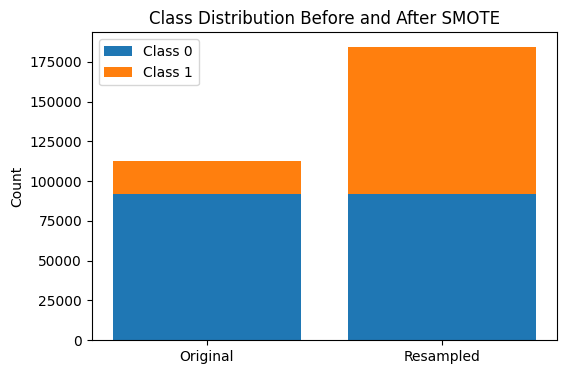

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train_smote)}")
plt.figure(figsize=(6, 4))
plt.bar(['Original', 'Resampled'], [Counter(y_train)[0], Counter(y_train_smote)[0]], label='Class 0')
plt.bar(['Original', 'Resampled'], [Counter(y_train)[1], Counter(y_train_smote)[1]], bottom=[Counter(y_train)[0], Counter(y_train_smote)[0]], label='Class 1')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE')
plt.legend()
plt.show()

In [47]:
train_accs = []
test_accs= []
train_f1s = []
test_f1s = []
train_pres = []
test_pres = []
train_recs = []
test_recs = []

for depth in max_depth:
    for split in min_samples_split:
            model = RandomForestClassifier(max_depth=depth, min_samples_split=split, n_jobs=-1, n_estimators=128, random_state=42)
            model.fit(X_train_smote, y_train_smote)

            train_acc = accuracy_score(y_train_smote, model.predict(X_train_smote))
            test_acc = accuracy_score(y_test, model.predict(X_test_processed))
            train_f1 = f1_score(y_train_smote, model.predict(X_train_smote))
            test_f1 = f1_score(y_test, model.predict(X_test_processed))
            train_pre = precision_score(y_train_smote, model.predict(X_train_smote))
            test_pre = precision_score(y_test, model.predict(X_test_processed))
            train_rec = recall_score(y_train_smote, model.predict(X_train_smote))
            test_rec = recall_score(y_test, model.predict(X_test_processed))

            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            train_pres.append(train_pre)
            test_pres.append(test_pre)
            train_recs.append(train_rec)
            test_recs.append(test_rec)

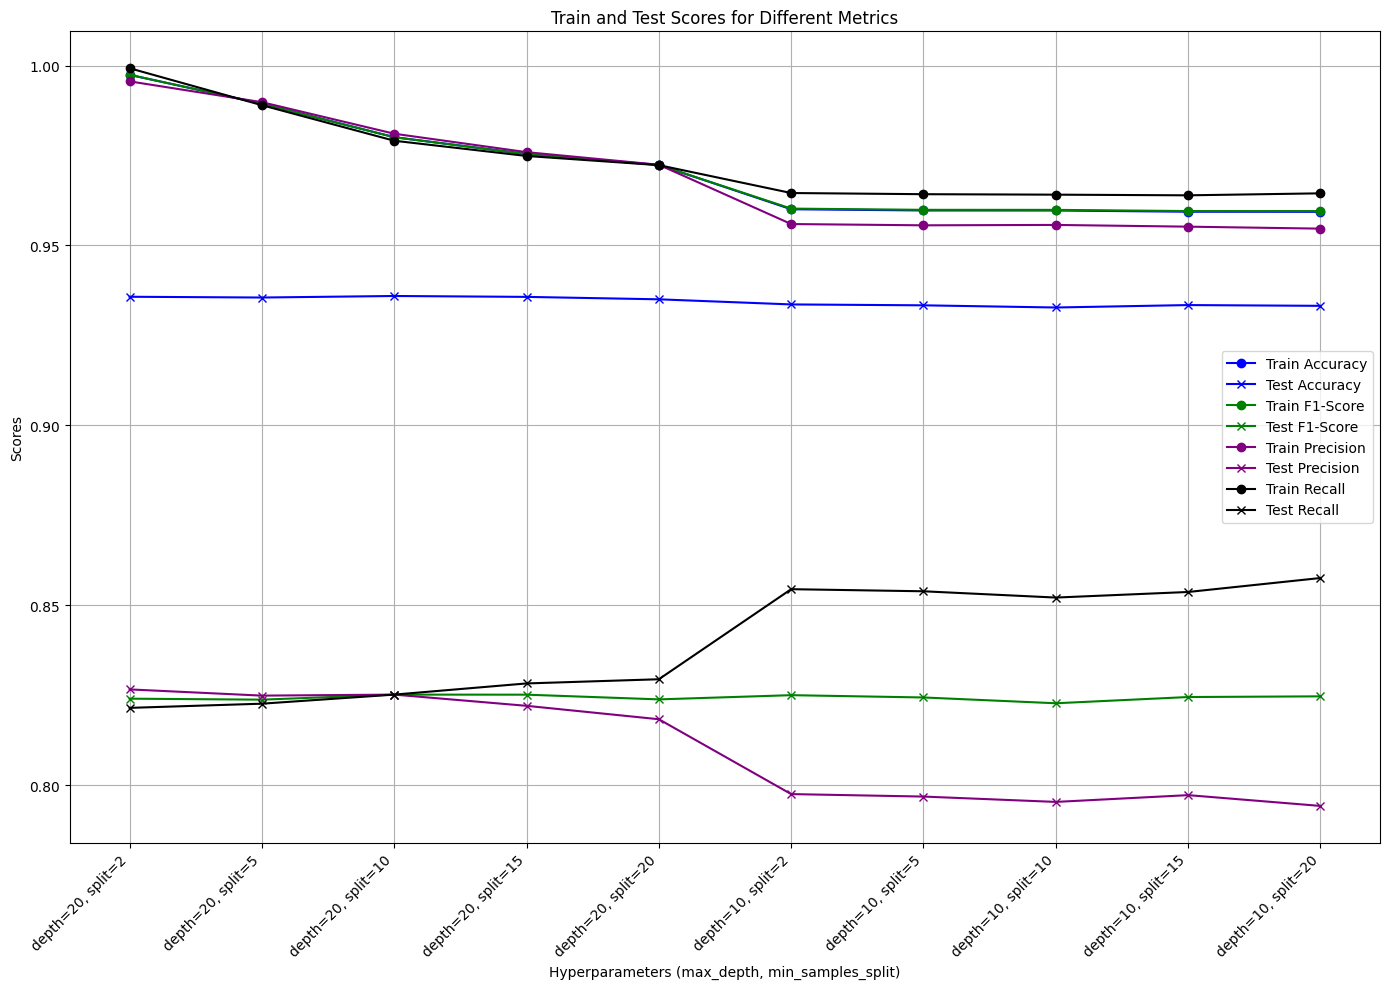

In [48]:
x_labels = [f"depth={d}, split={s}" for d in max_depth for s in min_samples_split]
x_range = np.arange(len(x_labels))

# Tạo đồ thị tổng hợp
plt.figure(figsize=(14, 10))

# Accuracy
plt.plot(x_range, train_accs, label='Train Accuracy', marker='o', color='blue')
plt.plot(x_range, test_accs, label='Test Accuracy', marker='x', color='blue')

# F1-Score
plt.plot(x_range, train_f1s, label='Train F1-Score', marker='o', color='green')
plt.plot(x_range, test_f1s, label='Test F1-Score', marker='x', color='green')

# Precision
plt.plot(x_range, train_pres, label='Train Precision', marker='o', color='purple')
plt.plot(x_range, test_pres, label='Test Precision', marker='x', color='purple')

# Recall
plt.plot(x_range, train_recs, label='Train Recall', marker='o', color='black')
plt.plot(x_range, test_recs, label='Test Recall', marker='x', color='black')

plt.xticks(x_range, x_labels, rotation=45, ha='right')
plt.xlabel('Hyperparameters (max_depth, min_samples_split)')

plt.ylabel('Scores')
plt.title('Train and Test Scores for Different Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
rfc = RandomForestClassifier(min_samples_split=10, max_depth=20, n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train_smote, y_train_smote)
print(classification_report(y_test, rfc.predict(X_test_processed)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.83      0.83      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.89      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



## Mô hình được lựa chọn

In [21]:
rfc = RandomForestClassifier(\
    min_samples_split=5, max_depth=20, \
    n_estimators=100, class_weight='balanced', 
    n_jobs=-1, random_state=42)

rfc.fit(X_train_processed, y_train)
y_pred = rfc.predict(X_test_processed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.82      0.83      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.89      0.90      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [16]:
# Lấy mức độ quan trọng của tính năng
feature_importance = rfc.feature_importances_

# Hiển thị mức độ quan trọng
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                  Feature  Importance
0                                  Gender    0.350067
1                                     Age    0.100353
15                       Financial Stress    0.087075
3         Working Professional or Student    0.067916
2                                    City    0.050790
4                              Profession    0.046935
5                       Academic Pressure    0.045543
8                      Study Satisfaction    0.044257
7                                    CGPA    0.037451
11                         Dietary Habits    0.033952
14                       Work/Study Hours    0.033601
10                         Sleep Duration    0.032808
12                                 Degree    0.023427
13  Have you ever had suicidal thoughts ?    0.017390
6                           Work Pressure    0.015767
9                        Job Satisfaction    0.006399
16       Family History of Mental Illness    0.006270


In [18]:
print(feature_importance.sum())

1.0


In [26]:
from sklearn.inspection import permutation_importance

# Tính mức độ quan trọng bằng hoán vị
result = permutation_importance(rfc, X_train_processed, y_train, scoring='f1', n_repeats=10, random_state=42, n_jobs=-1)

# Hiển thị kết quả
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                  Feature  Importance
0                                  Gender    0.329833
15                       Financial Stress    0.176235
1                                     Age    0.130803
8                      Study Satisfaction    0.112359
7                                    CGPA    0.080328
2                                    City    0.070994
13  Have you ever had suicidal thoughts ?    0.060348
5                       Academic Pressure    0.053939
14                       Work/Study Hours    0.048279
10                         Sleep Duration    0.044162
6                           Work Pressure    0.043289
12                                 Degree    0.031205
3         Working Professional or Student    0.026785
4                              Profession    0.025682
16       Family History of Mental Illness    0.021141
9                        Job Satisfaction    0.018036
11                         Dietary Habits    0.000652


In [28]:
df['City'].unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', '